# TP OpenMP - October 2022

## Part 1 : Pi

### Compilation

#### Cleaning

In [24]:
!rm tp_openmp_part_1_pi_impl_critical
!rm tp_openmp_part_1_pi_impl_atomic
!rm tp_openmp_part_1_pi_impl_reduce
!rm tp_openmp_part_1_pi_impl_split

rm: cannot remove 'tp_openmp_part_1_pi_impl_critical': No such file or directory
rm: cannot remove 'tp_openmp_part_1_pi_impl_atomic': No such file or directory
rm: cannot remove 'tp_openmp_part_1_pi_impl_reduce': No such file or directory
rm: cannot remove 'tp_openmp_part_1_pi_impl_split': No such file or directory


##### Compiling

In [6]:
!g++ -o tp_openmp_part_1_pi_impl_reduce tp_openmp_part_1_pi_impl_reduce.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_atomic tp_openmp_part_1_pi_impl_atomic.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_critical tp_openmp_part_1_pi_impl_critical.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_split tp_openmp_part_1_pi_impl_split.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [3]:
import os
import subprocess
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

try:
    os.remove("pi_stats.csv")
except OSError:
    pass

# Creating the output csv file
with open("pi_stats.csv", "w") as stat_file:
    writer = csv.writer(stat_file)

num_steps = [10000, 1000000, 100000000]#, 1000000000000]
nb_core = [1, 2, 4, 8]
repeats = range(0,10)

for nsteps in num_steps:
    for ncore in nb_core:
        for repeat in repeats:
            args = ("./tp_openmp_part_1_pi_impl_reduce", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("./tp_openmp_part_1_pi_impl_atomic", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("./tp_openmp_part_1_pi_impl_critical", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("./tp_openmp_part_1_pi_impl_split", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()





### Performance analysis
#### Weak scaling

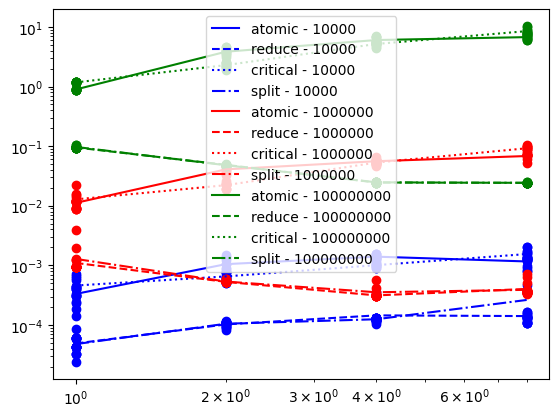

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('pi_stats.csv',header=None,names=['version','nbcore','num_steps','runtime'],dtype={
                     'version': str,
                     'nbcore': int,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {10000 : "blue", 1000000 : "red", 100000000 : "green"}
linestyle_version = {"atomic" : "solid", "reduce" : "dashed", "critical" : "dotted", "split" : "dashdot"}

for num_steps in color_num_steps:
    for version in linestyle_version:

        df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == version)]
        mean_stats = df_plot.groupby(['num_steps','version','nbcore']).mean().reset_index()

        plt.plot(mean_stats['nbcore'], mean_stats['runtime'],linestyle=linestyle_version[version],color=color_num_steps[num_steps], label=version+" - "+str(num_steps))
        plt.yscale('log')
        plt.xscale('log')
        plt.scatter(df_plot['nbcore'], df_plot['runtime'],color=color_num_steps[num_steps])



plt.legend()
plt.show()

#### Strong Scaling

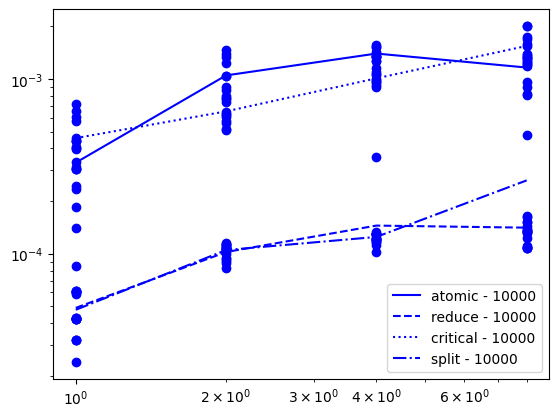

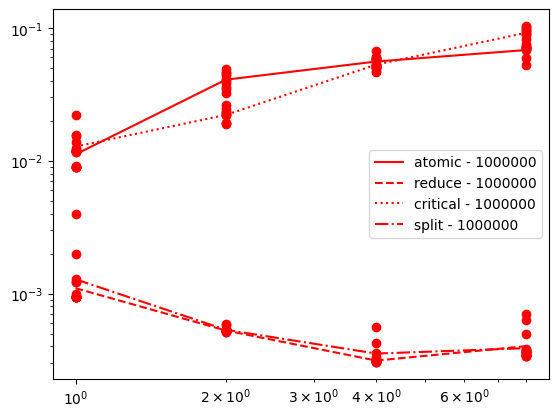

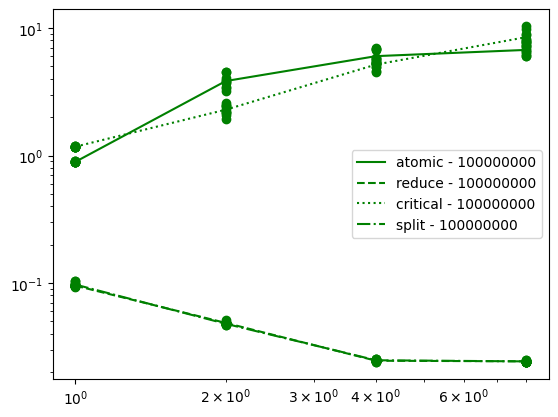

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('pi_stats.csv',header=None,names=['version','nbcore','num_steps','runtime'],dtype={
                     'version': str,
                     'nbcore': int,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {10000 : "blue", 1000000 : "red", 100000000 : "green"}
linestyle_version = {"atomic" : "solid", "reduce" : "dashed", "critical" : "dotted", "split" : "dashdot"}

for num_steps in color_num_steps:
    for version in linestyle_version:

        df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == version)]
        mean_stats = df_plot.groupby(['num_steps','version','nbcore']).mean().reset_index()

        plt.plot(mean_stats['nbcore'], mean_stats['runtime'],linestyle=linestyle_version[version],color=color_num_steps[num_steps], label=version+" - "+str(num_steps))
        plt.yscale('log')
        plt.xscale('log')
        plt.scatter(df_plot['nbcore'], df_plot['runtime'],color=color_num_steps[num_steps])
    
    plt.legend()
    plt.show()


### Discussion

About the critical version:
This version is also one of the worst as we expected. Indeed, the "sum" variable is shared. It means that all the threads can update it. By adding the pragma "atomic", we're allowing one thread at a time to update it. However, as there are so many times the threads are updating the value, they are forced to wait eachother which slows the program.

About the atomic version:
It seems to be one of the worst implementation. It works quite like the critical version. We should have technically observed that it is better than the critical version as the atomic is handled by the hardware, but we couldn't prove it. We might see better results with even more steps.

About the reduce version:
We observed very good results on the reduce version. The idea of the reduction is to split an operation on a shared variable. As we had so many additions to perform, each thread did it partially and the final result was obtained by adding all of the partial sums from each thread (which is why the performance increased with the number of cores).

About the split version:
This version is also nice. It is quite like a manual reduction. And given the data, the behaviors are very similar which confirms it.

## Part 2 : Matrix-Vector operation

### Compilation

#### Cleaning

In [47]:
!rm tp_openmp_part_2_vector_sequential
!rm tp_openmp_part_2_vector_parallel
!rm tp_openmp_part_2_vector_simd

#### Compiling

In [53]:
!g++ -o tp_openmp_part_2_vector_sequential tp_openmp_part_2_vector_sequential.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_2_vector_parallel tp_openmp_part_2_vector_parallel.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_2_vector_simd tp_openmp_part_2_vector_simd.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [50]:
import os
import subprocess
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

try:
    os.remove("vector_stats.csv")
except OSError:
    pass

# Creating the output csv file
with open("vector_stats.csv", "w") as stat_file:
    writer = csv.writer(stat_file)

nb_rows = [2, 4, 6, 8, 10, 12, 14, 16]
nb_columns = [1, 3, 5, 7, 9, 11, 13, 15]
nb_core = [1, 2, 4, 8]

for i in range(len(nb_rows)):
    for ncore in nb_core:
        args = ("./tp_openmp_part_2_vector_sequential", "-N", str(nb_rows[i]), "-M", str(nb_columns[i]), "-C", str(ncore))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        args = ("./tp_openmp_part_2_vector_parallel", "-N", str(nb_rows[i]), "-M", str(nb_columns[i]), "-C", str(ncore))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        args = ("./tp_openmp_part_2_vector_simd", "-N", str(nb_rows[i]), "-M", str(nb_columns[i]), "-C", str(ncore))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()






### Performance Analysis

#### Weak scaling

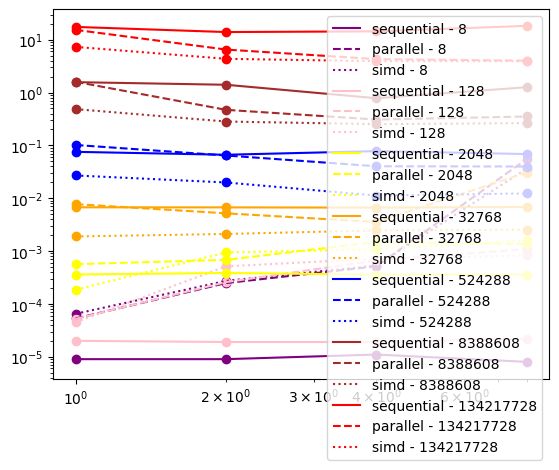

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('vector_stats.csv',header=None,names=['version','nbcore','size','runtime'],dtype={
                     'version': str,
                     'nbcore': int,
                     'size' : int,
                     'runtime' : float
                 })

sizes = df['size'].unique()
colors = {"blue", "red", "green", "yellow", "purple", "orange", "pink", "brown"}
color_size = {}
for size in sizes:
    color_size[size] = colors.pop()

linestyle_version = {"sequential" : "solid", "parallel" : "dashed", "simd" : "dotted"}

for size in color_size:
    for version in linestyle_version:

        df_plot = df[(df['size'] == size) & (df['version'] == version)]
        mean_stats = df_plot.groupby(['size','version','nbcore']).mean().reset_index()

        plt.plot(mean_stats['nbcore'], mean_stats['runtime'],linestyle=linestyle_version[version],color=color_size[size], label=version+" - "+str(size))
        plt.yscale('log')
        plt.xscale('log')
        plt.scatter(df_plot['nbcore'], df_plot['runtime'],color=color_size[size])

plt.legend()
plt.show()


#### Strong scaling

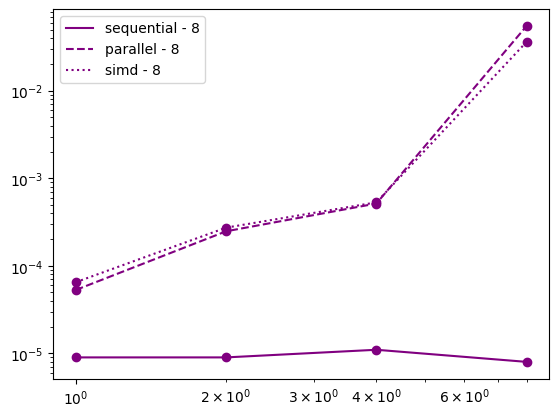

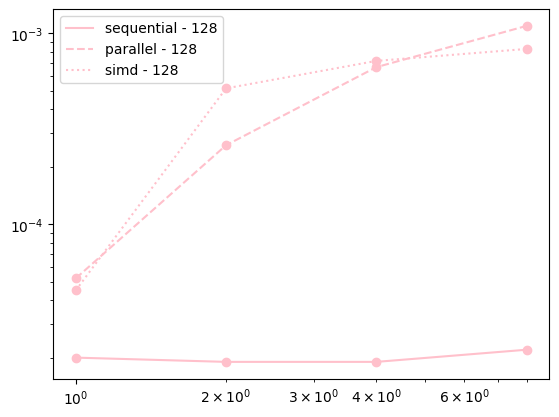

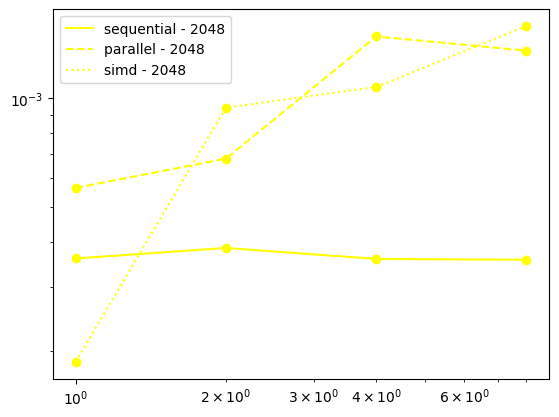

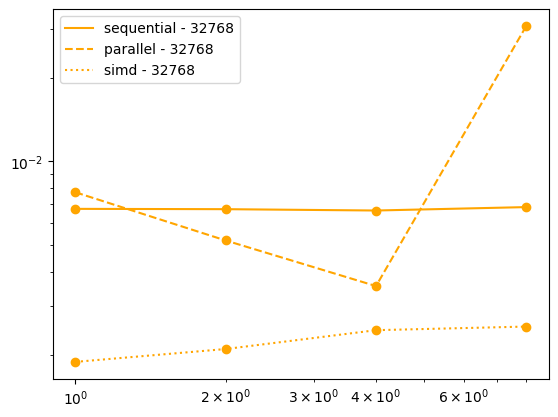

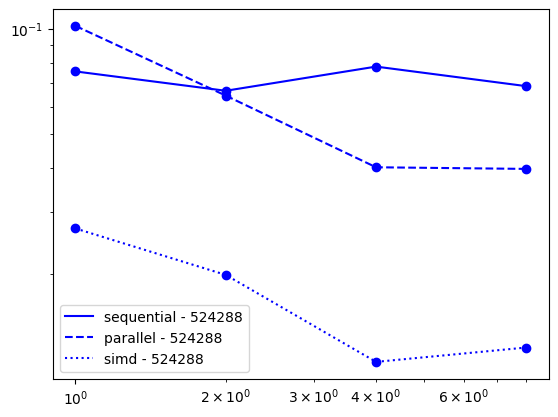

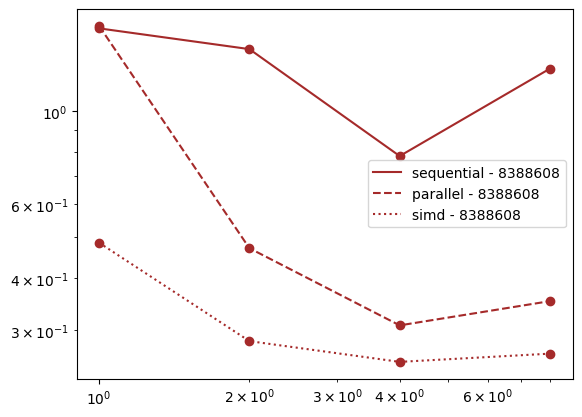

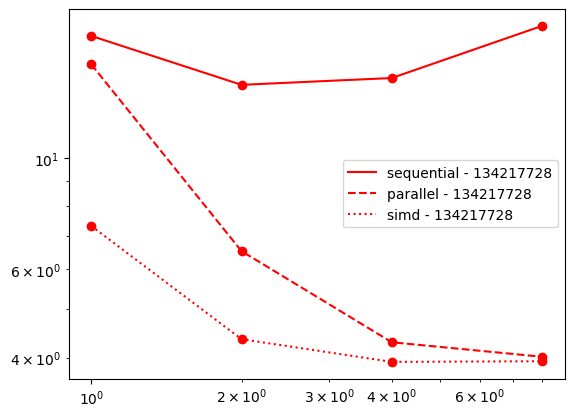

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('vector_stats.csv',header=None,names=['version','nbcore','size','runtime'],dtype={
                     'version': str,
                     'nbcore': int,
                     'size' : int,
                     'runtime' : float
                 })

sizes = df['size'].unique()
colors = {"blue", "red", "green", "yellow", "purple", "orange", "pink", "brown"}
color_size = {}
for size in sizes:
    color_size[size] = colors.pop()

linestyle_version = {"sequential" : "solid", "parallel" : "dashed", "simd" : "dotted"}

for size in color_size:
    for version in linestyle_version:

        df_plot = df[(df['size'] == size) & (df['version'] == version)]
        mean_stats = df_plot.groupby(['size','version','nbcore']).mean().reset_index()

        plt.plot(mean_stats['nbcore'], mean_stats['runtime'],linestyle=linestyle_version[version],color=color_size[size], label=version+" - "+str(size))
        plt.yscale('log')
        plt.xscale('log')
        plt.scatter(df_plot['nbcore'], df_plot['runtime'],color=color_size[size])
    plt.legend()
    plt.show()


### Discussion

About the sequential version:
It is the basic implementation without trying to use parallelism. However, I still used different number of cores to maybe reveal hidden compiling optimisations. The weak scaling results show a constant runtime regardless the number of cores. It increases with the problem size which is normal.

About the parallel version:
The strong scaling results are very surprising. We expected this version to perform better than the sequential on the problem's biggest instances, which is confirmed. However, we also observe that on the problem's smallest instances, not only the performance is weak, but it gets even worse when we increase the number of cores used. My supposition on this is that splitting the tasks on every thread and adding the atomic update is so overkill that it makes the execution time longer.

About the simd version:
The behavior is quite similar to the parallel version. It is still better, it is based on the reduction principle.

## Part 3 : Fibonacci and linked list

### Compilation

#### Cleaning

In [11]:
!rm tp_openmp_part_3_fib_sequential
!rm tp_openmp_part_3_fib_parallel

#### Compiling

In [12]:
!g++ -o tp_openmp_part_3_fib_sequential tp_openmp_part_3_fib_sequential.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_3_fib_parallel tp_openmp_part_3_fib_parallel.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [14]:
import os
import subprocess
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

try:
    os.remove("fib_stats.csv")
except OSError:
    pass

# Creating the output csv file
with open("fib_stats.csv", "w") as stat_file:
    writer = csv.writer(stat_file)

nb_node = [4, 5, 6, 7, 8, 9]
nb_core = [1, 2, 4, 8]

for i in range(len(nb_node)):
    for ncore in nb_core:
        args = ("./tp_openmp_part_3_fib_sequential", "-N", str(nb_node[i]), "-C", str(ncore))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        args = ("./tp_openmp_part_3_fib_parallel", "-N", str(nb_node[i]), "-C", str(ncore))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()






### Performance Analysis

#### Weak scaling

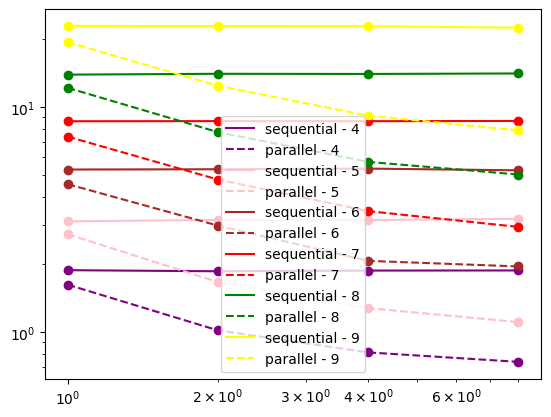

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('fib_stats.csv',header=None,names=['version','nbcore','nbnode','runtime'],dtype={
                     'version': str,
                     'nbcore': int,
                     'nbnode' : int,
                     'runtime' : float
                 })

nbnodes = df['nbnode'].unique()
colors = {"blue", "red", "green", "yellow", "purple", "orange", "pink", "brown"}
color_nbnode = {}
for nbnode in nbnodes:
    color_nbnode[nbnode] = colors.pop()

linestyle_version = {"sequential" : "solid", "parallel" : "dashed"}

for nbnode in color_nbnode:
    for version in linestyle_version:

        df_plot = df[(df['nbnode'] == nbnode) & (df['version'] == version)]
        mean_stats = df_plot.groupby(['nbnode','version','nbcore']).mean().reset_index()

        plt.plot(mean_stats['nbcore'], mean_stats['runtime'],linestyle=linestyle_version[version],color=color_nbnode[nbnode], label=version+" - "+str(nbnode))
        plt.yscale('log')
        plt.xscale('log')
        plt.scatter(df_plot['nbcore'], df_plot['runtime'],color=color_nbnode[nbnode])

plt.legend()
plt.show()
